In [2]:
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

In [3]:
# Load data
X = torch.load("X_timeseries_large.pt").numpy()  # shape: [N, T]
y = torch.load("y_params_large.pt").numpy()                 # shape: [N, 3]

# Train/Val split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize
X_scaler = StandardScaler()
y_scaler = StandardScaler()
X_train_scaled = X_scaler.fit_transform(X_train)
y_train_scaled = y_scaler.fit_transform(y_train)
X_val_scaled = X_scaler.transform(X_val)
y_val_scaled = y_scaler.transform(y_val)

# Convert to tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32).unsqueeze(1)
y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32).unsqueeze(1)
y_val_tensor = torch.tensor(y_val_scaled, dtype=torch.float32)

# DataLoaders
batch_size = 1024
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=batch_size)

In [4]:
# class TimeSeriesCNN(nn.Module):
#     def __init__(self, output_size=3):
#         super().__init__()
#         self.conv = nn.Sequential(
#             nn.Conv1d(1, 32, 7, padding=3), nn.ReLU(), nn.MaxPool1d(2),
#             nn.Conv1d(32, 64, 5, padding=2), nn.ReLU(), nn.MaxPool1d(2),
#             nn.Conv1d(64, 128, 3, padding=1), nn.ReLU()
#         )
#         self.avgpool = nn.AdaptiveAvgPool1d(1)
#         self.head = nn.Sequential(
#             nn.Flatten(),
#             nn.Linear(128, 64), nn.ReLU(),
#             nn.Linear(64, output_size)
#         )

#     def forward(self, x):
#         x = self.conv(x)
#         x = self.avgpool(x)
#         return self.head(x)


In [5]:
class TimeSeriesCNN(nn.Module):
    def __init__(self, output_size=3):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(1, 32, 7, padding=3), nn.ReLU(), nn.MaxPool1d(2),
            nn.Conv1d(32, 64, 5, padding=2), nn.ReLU(), nn.MaxPool1d(2),
            nn.Conv1d(64, 128, 3, padding=1), nn.ReLU()
        )
        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128, 64), nn.ReLU(),
            nn.Linear(64, 32), nn.ReLU(),
            nn.Linear(32, 16), nn.ReLU(),
            nn.Linear(16, output_size)
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.avgpool(x)
        return self.head(x)


In [6]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
    
model = TimeSeriesCNN(output_size=3).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.5)

Epoch 1/150, Train Loss: 0.734746, Val Loss: 0.669910


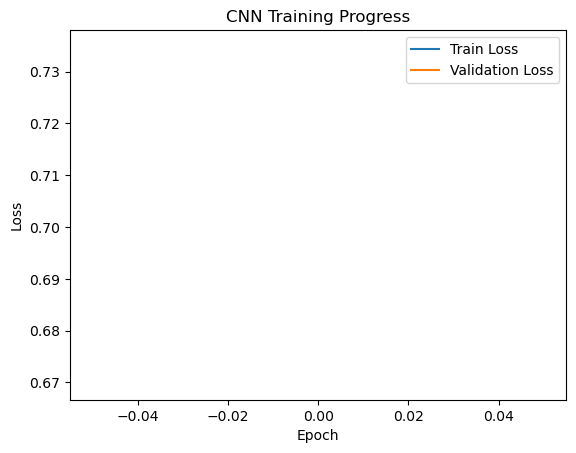

Epoch 11/150, Train Loss: 0.490018, Val Loss: 0.485979


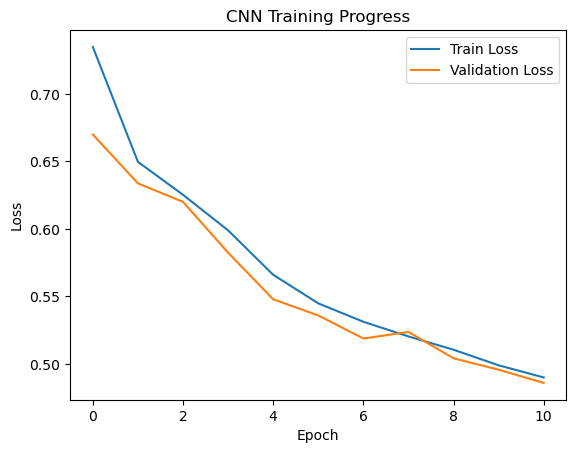

Epoch 21/150, Train Loss: 0.432045, Val Loss: 0.433632


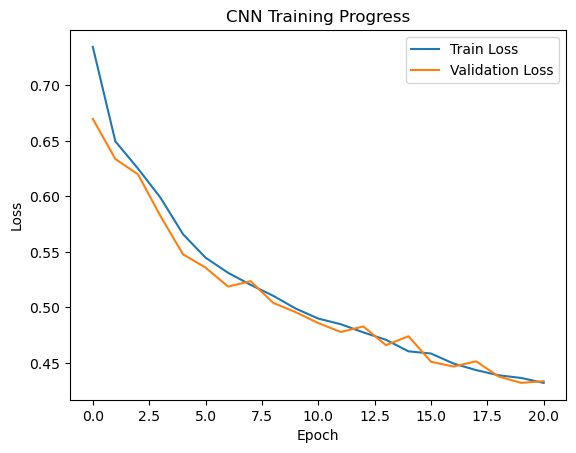

Epoch 31/150, Train Loss: 0.399718, Val Loss: 0.400385


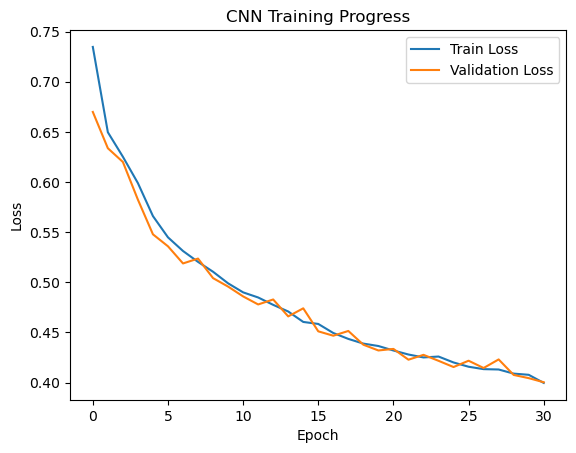

Epoch 41/150, Train Loss: 0.389904, Val Loss: 0.396348


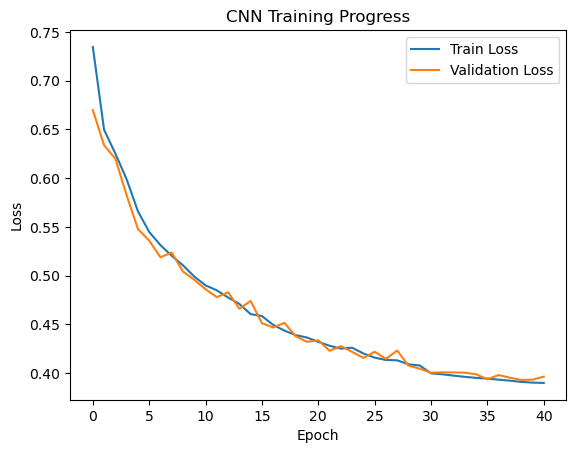

Epoch 51/150, Train Loss: 0.383732, Val Loss: 0.386075


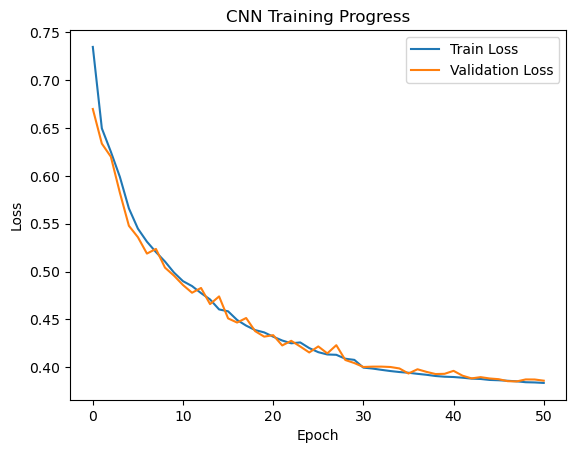

Epoch 61/150, Train Loss: 0.375109, Val Loss: 0.377276


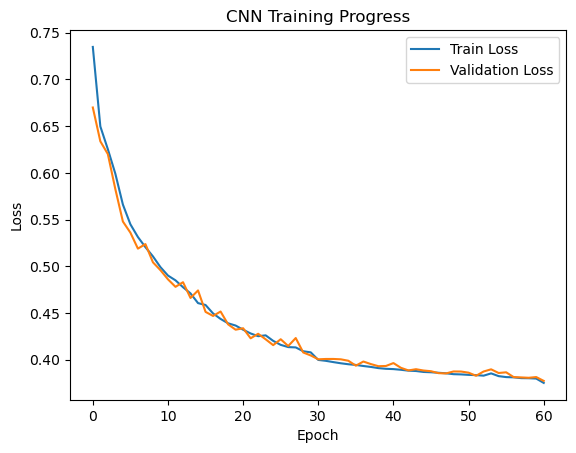

Epoch 71/150, Train Loss: 0.372611, Val Loss: 0.374234


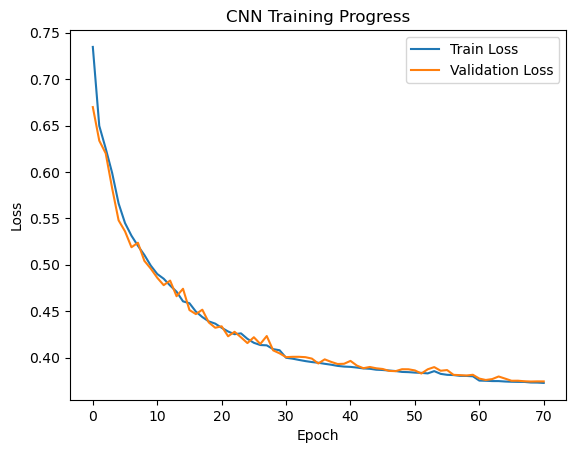

Epoch 81/150, Train Loss: 0.370849, Val Loss: 0.371069


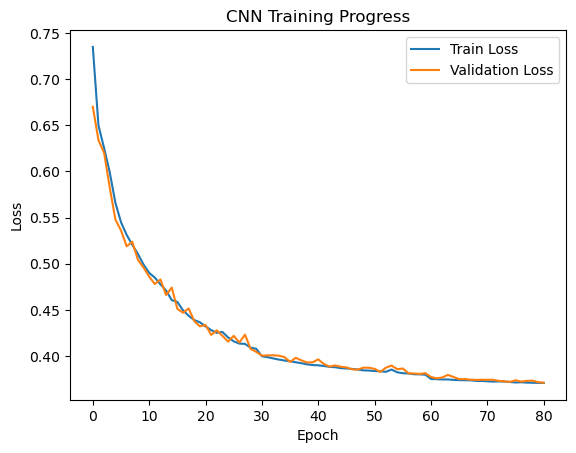

KeyboardInterrupt: 

In [7]:
import matplotlib.pyplot as plt
num_epochs = 150
train_losses = []
val_losses = []

plt.ion()

# Training loop
for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0.0

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)

        pred = model(xb)
        loss = criterion(pred, yb)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    total_val_loss = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb)
            total_val_loss += criterion(pred, yb).item() * xb.size(0)

    avg_val_loss = total_val_loss / len(val_loader.dataset)
    val_losses.append(avg_val_loss)
    scheduler.step()

    # Live plot every 10 epochs
    if epoch % 10 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}")
        plt.clf()
        plt.plot(train_losses, label="Train Loss")
        plt.plot(val_losses, label="Validation Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("CNN Training Progress")
        plt.legend()
        plt.pause(0.1)

plt.ioff()
plt.show()

In [8]:
def predict_single(model, x_tensor, device):
    model.eval()
    with torch.no_grad():
        x_tensor = x_tensor.unsqueeze(0).to(device)
        return model(x_tensor).cpu()

In [9]:
predict_single(model, X_val_tensor[1], device)

tensor([[-0.4479, -1.4241, -0.0017]])

In [10]:
y_val_tensor[1]

tensor([-1.0440, -1.4063,  0.8963])

In [11]:
torch.save(model.state_dict(), "cnn_model_weights_large_2.pth")

In [ ]:
# Instantiate the model
model = TimeSeriesCNN()

# Load the state dict (recommended approach)
model.load_state_dict(torch.load("cnn_model_weights_large.pth"))

# Or load full model (if saved that way)
# model = torch.load('model.pth')
x_tensor=X_val_tensor[1]
model.eval()
with torch.no_grad():
    x_tensor = x_tensor.unsqueeze(0).to(device)
    model(x_tensor).cpu()